In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.update()
Pkg.instantiate()

In [17]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

simulation_sweep (generic function with 1 method)

In [3]:
dt = 0.1
velocity_max = 2.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 2.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([0.5; 0.5]) 
Qt = diagm([5.; 5.; 0.; 0.])
markup = 1.15
collision_slack = 300.
trust_region_weight = 0.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = .75
inconvenience_ratio = 100.


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 2.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 2.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([0.5; 0.5]) 
Qt = diagm([5.; 5.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [0.5 0.0; 0.0 0.5]
  Qt: Array{Float64}((4, 4)) [5.0 0.0 0.0 0.0; 0.0 5.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.15
  collision_slack: Float64 300.0
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 0.75
  inconvenience_ratio: Float64 100.0


In [4]:
robot_initial_state = [5.; -5.; pi / 2; 1.5]
robot_goal_state = [5.; 10.; pi / 2; 0.]
human_initial_state = [5.; 5.; -pi / 2; 1.5]
human_goal_state = [5.; -10.; -pi / 2; 0.]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


# Multi Agent Support

In [18]:
ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(ip.ego_planner.incon, velo_agent_1)
add_constant_velocity_agent(ip.other_planner.incon, velo_agent_1)

In [19]:
@time ibr(ip, 10, "ego", velo_agent_1)

  0.147229 seconds (884.80 k allocations: 74.873 MiB, 13.80% gc time)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


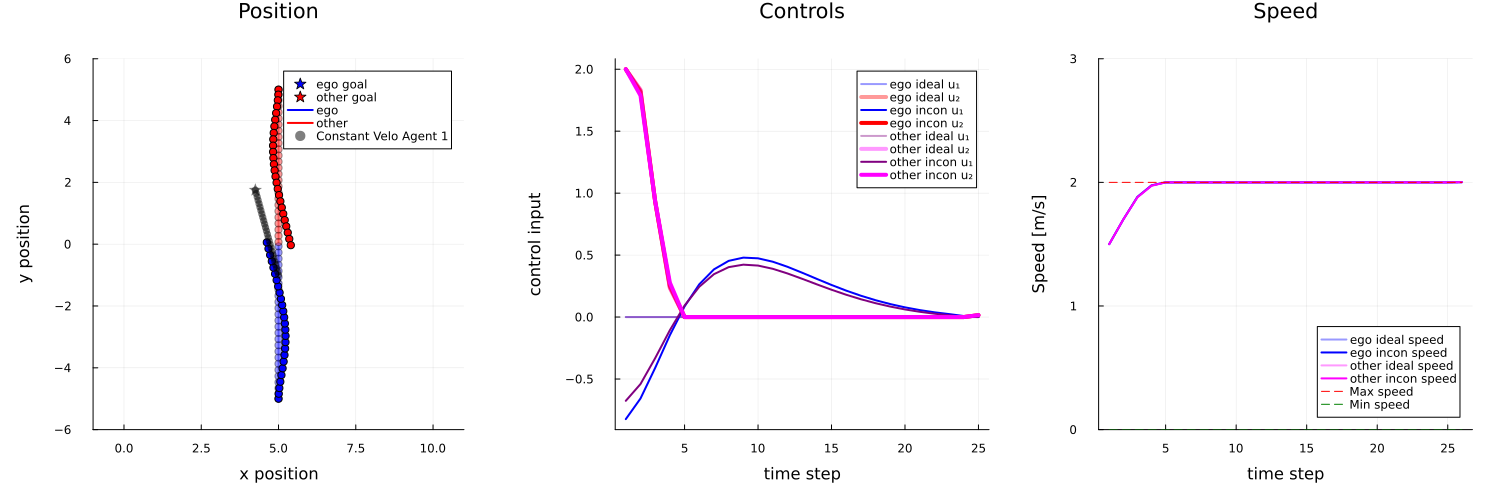

In [20]:
plot_solve_solution(ip, velo_agent_1, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

In [16]:
print("ζ: $(value(ip.other_planner.incon.model[:ζ])), ϵ: $(value(ip.other_planner.incon.model[:ϵ]))")

ζ: 2.6384971612660753, ϵ: 9.090385886623243e-9

┌ Info: Saved animation to /tmp/jl_BGdydu52by.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_BGdydu52by.gif")
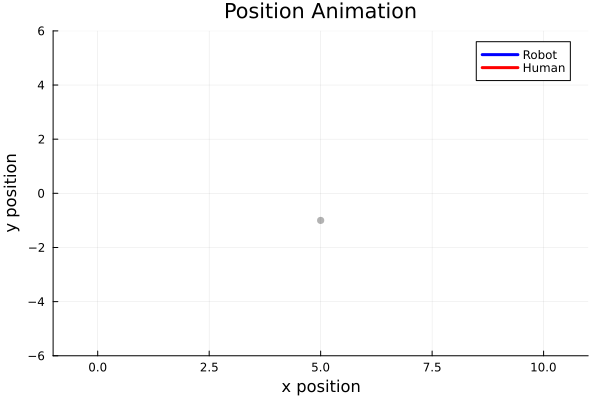

In [9]:
animation(ip, velo_agent_1, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Simulation Implementation

In [27]:
robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# constant velo agents
velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
velo_agent_2 = ConstantVeloAgent([4.5, -1.], [0.9, 0.4])
velo_agent_3 = ConstantVeloAgent([8., -4.], [-0.6, 0.2])

add_constant_velocity_agent(robot_ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(robot_ip.other_planner.incon, velo_agent_1, velo_agent_2)

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)
# constant velo agents
# velo_agent_1 = ConstantVeloAgent([5., -1.], [-0.3, 1.1])
# velo_agent_2 = ConstantVeloAgent([6.5, -2.], [-0.9, 0.4])

add_constant_velocity_agent(human_ip.ego_planner.incon, velo_agent_1, velo_agent_2)
add_constant_velocity_agent(human_ip.other_planner.incon, velo_agent_1, velo_agent_2)

In [28]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params)
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [0.5 0.0; 0.0 0.5]
  Qt: Array{Float64}((4, 4)) [5.0 0.0 0.0 0.0; 0.0 5.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.15
  collision_slack: Float64 300.0
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 0.75
  inconvenience_ratio: Float64 100.0
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-0.5624999999999716, -0.5624999999999716, -0.5624999999900524, -0.5624999999622986, -0.5624999999145786, -0.5624999998468923, -0.5624999997592255, -0.562499999654257, -0.5624999995346727, -0.5624

In [29]:
robot_xs, robot_us, human_xs, human_us = simulate(robot_ip, human_ip, 50, velo_agent_1, velo_agent_2, ibr_iterations=10)

([5.0 -5.0 1.5707963267948966 1.5; 5.006224778418975 -4.840159881321171 1.4945369955828123 1.69999995127388; … ; 4.708069705887104 4.66047519951226 1.5161974155810016 1.9999999888346507; 4.718984063484767 4.860177168221593 1.516193116187126 1.999999986573011], [-0.7625933121208427 1.9999995127387993; 0.9999998306206497 1.860023210467021; … ; -5.494790558779753e-5 3.9166542151131035e-8; -4.299393875544935e-5 -2.2616398710550737e-8], [5.0 5.0 -1.5707963267948966 1.5; 5.008007435079122 4.840264684691299 -1.4726660949533013 1.6999999792580711; … ; 5.396299738827057 -4.615563121741261 -1.6442382754252236 1.9999999767642938; 5.381624549882751 -4.815023989897128 -1.6442441454770167 1.999999978037854], [0.9813023184159531 1.9999997925807123; 0.46212021901330086 1.9036389428616607; … ; -7.399514263057333e-5 -1.5922041860726933e-9; -5.870051793152128e-5 1.2735601266344305e-8])

In [31]:
sim_data = SimData(sim_params, robot_xs, robot_us, human_xs, human_us)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [0.5 0.0; 0.0 0.5]
  Qt: Array{Float64}((4, 4)) [5.0 0.0 0.0 0.0; 0.0 5.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.15
  collision_slack: Float64 300.0
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 0.75
  inconvenience_ratio: Float64 100.0
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [5.9750243612814415, 5.693706125984207, 5.412366818540178, 5.131010446073631, 4.849640203395822, 4.568258668658075, 4.286867961536586, 4.005469836148393, 3.724065732568903, 3.4426568203409

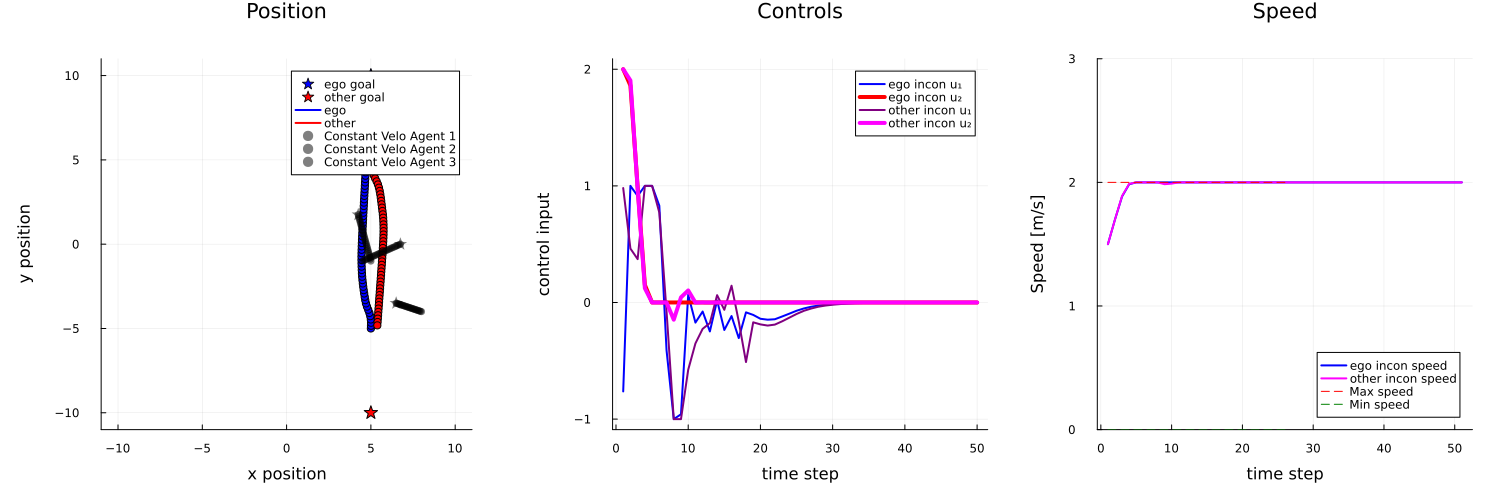

In [32]:
plot_solve_solution(sim_data, velo_agent_1, velo_agent_2, velo_agent_3, pos_xlims=[-11, 11], pos_ylims=[-11, 11])

In [30]:
# bad plotting code but used for animation demonstration

function animation(ego_path::Matrix{Float64}, other_path::Matrix{Float64}, dt::Float64, constant_velo_agents::ConstantVeloAgent...; pos_xlims=[-1, 8], pos_ylims=[-3, 3], save_name="none")
    a = Animation()

    linewidth = 3
    alpha_ideal = 0.2
    ego_color = :blue
    other_color = :red

    markersize=20
    ego_xs = ego_path
    other_xs = other_path

    time_steps = length(ego_path[:, 1])

    N_velo_agents = length(constant_velo_agents)
    constant_velo_agents_pos = Vector{Matrix{Float64}}(undef, N_velo_agents)
    
    for i in 1:N_velo_agents
        pos = constant_velo_agents[i].pos
        velo = constant_velo_agents[i].velo
        constant_velo_agents_pos[i] = vector_of_vectors_to_matrix([pos + velo * dt * j for j in 0:time_steps])
    end

    print(length(constant_velo_agents_pos[1]))

    constant_velo_length = length(constant_velo_agents_pos[1][:, 1])

    plt = plot(xlim=pos_xlims, ylim=pos_ylims, xlabel="x position", ylabel="y position", title="Position Animation", arrow=true, aspect_ration=:equal)


    for i in 1:length(ego_xs[:, 1]) - 1
        plt = plot(ego_xs[1:i,1], ego_xs[1:i,2], color=ego_color, linewidth=linewidth, lab="Robot Path", xlim=pos_xlims, ylim=pos_ylims, xlabel="x position", ylabel="y position", title="Position Animation", margin=10mm, titlefontsize=20, legendfontsize=13, labelfontsize=13, axisfontsize=13)
        plot!(plt, other_xs[1:i,1], other_xs[1:i,2], size=(1200, 800), color=other_color, linewidth=linewidth, lab="Human Path")
        scatter!(plt, ego_xs[i:i, 1], ego_xs[i:i, 2], color=:blue, alpha=0.3, markersize=markersize, label="Robot")
        scatter!(plt, other_xs[i:i, 1], other_xs[i:i, 2], color=:red, alpha=0.3, markersize=markersize, label="Human")

        scatter!(plt, [10000.], [10000.], color=:black, alpha=0.3, markersize=10, label="Non-interactive Humans")

        if i <= constant_velo_length
            for j in 1:N_velo_agents
                scatter!(plt, constant_velo_agents_pos[j][i:i, 1], constant_velo_agents_pos[j][i:i, 2], label="", color=:black, alpha=0.3, markersize=markersize)
            end
        end
        frame(a, plt)
    end

    if save_name != "none"
        gif(a, "../animations/$save_name.gif", fps = 10) 
    end 

    return gif(a, fps=15)
end

animation (generic function with 4 methods)

104

┌ Info: Saved animation to /tmp/jl_BC9uFKpwnU.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_BC9uFKpwnU.gif")
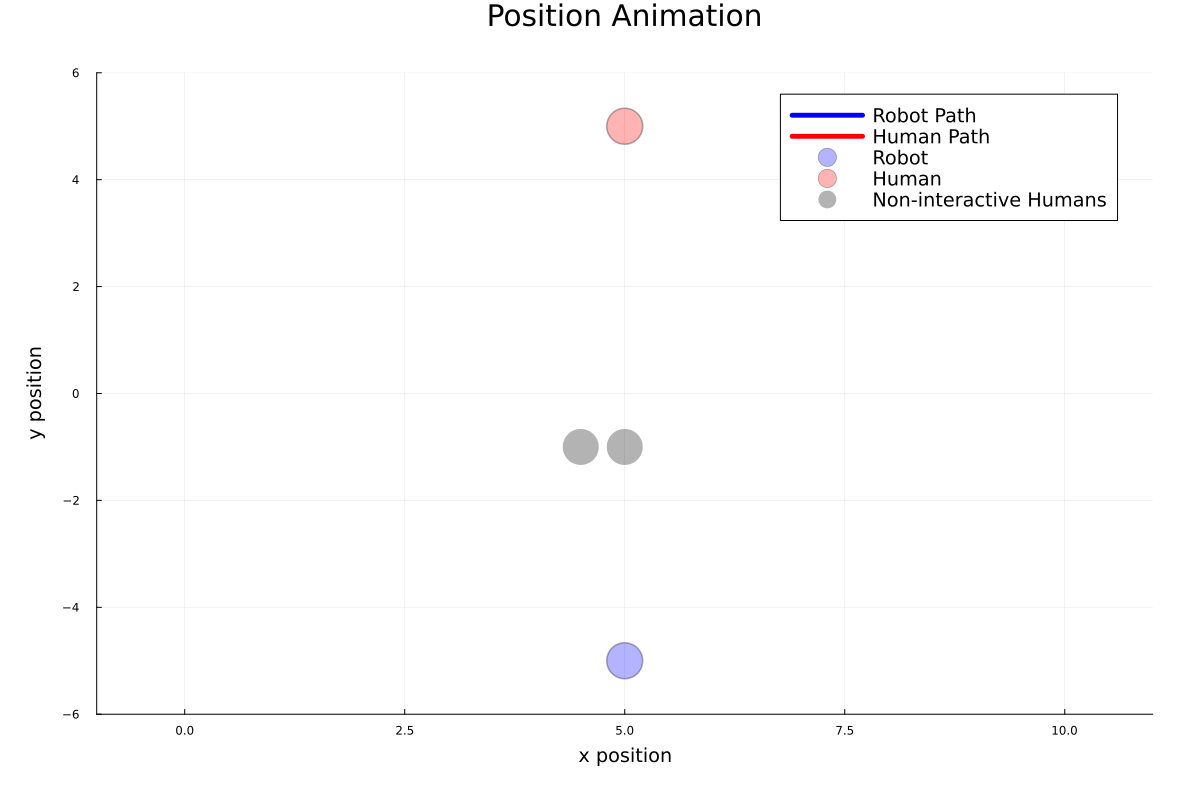

In [34]:
animation(robot_xs, human_xs, 0.1, velo_agent_1, velo_agent_2, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

In [18]:
# debugging simulation function

function simulate(ego_ip::InteractionPlanner, other_ip::InteractionPlanner, sim_horizon::Int64, constant_velo_agents::ConstantVeloAgent...; ibr_iterations=3::Int64, leader="ego"::String)
    # Given the IP problem setup of the ego agent and other agent
    # initialize matrices for saving the paths

    ego_dyn = ego_ip.ego_planner.incon.hps.dynamics
    other_dyn = other_ip.ego_planner.incon.hps.dynamics

    velo_agents = collect(constant_velo_agents)

    dt = ego_ip.ego_planner.incon.hps.dynamics.dt

    ego_traj = Vector{Vector{Float64}}(undef, sim_horizon + 1)
    ego_controls = Vector{Vector{Float64}}(undef, sim_horizon)
    other_traj = Vector{Vector{Float64}}(undef, sim_horizon + 1)
    other_controls = Vector{Vector{Float64}}(undef, sim_horizon)

    ego_traj[1] = ego_ip.ego_planner.incon.opt_params.initial_state
    other_traj[1] = other_ip.ego_planner.incon.opt_params.initial_state

    N_velo_agents = length(constant_velo_agents)
    copied_constant_velo_agents = deepcopy(constant_velo_agents)

    slack_vals = []
    ips = []
    ego_data = SaveData(Vector{InteractionPlanner}(undef, sim_horizon))
    other_data = SaveData(Vector{InteractionPlanner}(undef, sim_horizon))


    # Uses MPC function to simulate to a given time horizon
    for i in 1:(sim_horizon)
        ego_state = ego_traj[i]
        other_state = other_traj[i]
        # solve for the next iteration

        ego_control = mpc_step(ego_ip, ego_state, other_state, velo_agents, ibr_iterations=ibr_iterations, leader=leader)
        other_control = mpc_step(other_ip, other_state, ego_state, velo_agents, ibr_iterations=ibr_iterations, leader=leader)

        push!(slack_vals, (value(ego_ip.ego_planner.incon.model[:ϵ]), value(other_ip.ego_planner.incon.model[:ϵ])))
        push!(ips, (deepcopy(ego_ip), deepcopy(other_ip)))
        ego_data.previous_ips[i] = deepcopy(ego_ip)     # store data at each iteration
        other_data.previous_ips[i] = deepcopy(other_ip)     # store data at each iteration

        ego_state = step(ego_dyn, ego_state, ego_control)
        other_state = step(other_dyn, other_state, other_control)
        
        for j in 1:N_velo_agents
            copied_constant_velo_agents[j].pos .+= copied_constant_velo_agents[j].velo * dt
        end

        ego_traj[i+1] = ego_state
        other_traj[i+1] = other_state
        ego_controls[i] = ego_control
        other_controls[i] = other_control

    end

    # cast vector of vectors to matrix for easier plotting
    ego_traj = vector_of_vectors_to_matrix(ego_traj)
    ego_controls = vector_of_vectors_to_matrix(ego_controls)
    other_traj = vector_of_vectors_to_matrix(other_traj)
    other_controls = vector_of_vectors_to_matrix(other_controls)

    ego_traj, ego_controls, other_traj, other_controls, (slack_vals, constant_slack_vals, ips, ego_data, other_data)
end

simulate (generic function with 2 methods)

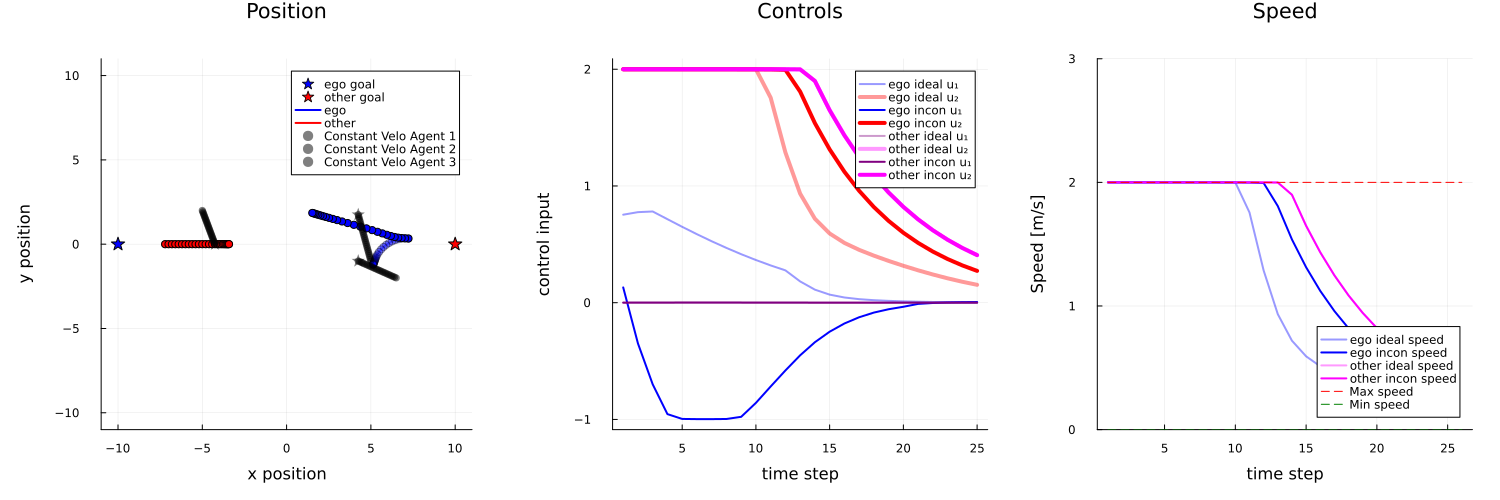

In [49]:
plot_solve_solution(debug[3][15][2], velo_agent_1, velo_agent_2, velo_agent_3, pos_xlims=[-11,11], pos_ylims=[-11,11])

In [10]:
# setup for problem with extra slack value for constant velo agents. Mostly for debugging purposes

function InconvenienceProblem(dyn::Dynamics, hps::PlannerHyperparameters, opt_params::PlannerOptimizerParams)
    n = dyn.state_dim
    m = dyn.ctrl_dim
    N = hps.time_horizon
    radius = hps.collision_radius
    solver = opt_params.solver

    if solver == "ECOS"
        model = Model(ECOS.Optimizer)
    elseif solver == "HiGHS"
        model = Model(HiGHS.Optimizer)
    elseif solver == "Gurobi"
        model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    end
    model[:x] = @variable(model, x[1:N+1,1:dyn.state_dim], base_name="x")
    model[:u] = @variable(model, u[1:N,1:dyn.ctrl_dim], base_name="u")
    model[:ϵ] = @variable(model, ϵ, base_name="ϵ")
    model[:ζ] = @variable(model, ζ, base_name="ζ")
    xs = matrix_to_vector_of_vectors(model[:x])
    us = matrix_to_vector_of_vectors(model[:u])
    ps = matrix_to_vector_of_vectors(get_position(dyn, model[:x]))

    @objective(model, Min, compute_running_quadratic_cost(xs[1:N], hps.Q, markup=hps.markup) + compute_running_quadratic_cost(us[1:N], hps.R, markup=hps.markup) + compute_quadratic_error_cost(xs[end], opt_params.goal_state, hps.Qt) + hps.trust_region_weight * (compute_running_quadratic_cost(xs - opt_params.previous_states, Matrix{Float64}(I, n, n)) + compute_running_quadratic_cost(us - opt_params.previous_controls, Matrix{Float64}(I, m, m))) + hps.collision_slack * model[:ϵ] + 15 * hps.collision_slack * model[:ζ])

    # slack variable positivity constraint
    model[:con_ϵ] = @constraint(model, ϵ >= 0)
    model[:con_ζ] = @constraint(model, ζ >= 0)

    # initial state constraint
    model[:initial_state] = @constraint(model, xs[1] == opt_params.initial_state, base_name="initial_state")

    # dynamic and collision avoidance constraints
    for t in 1:N
        model[Symbol("linear_dynamics_constraint_$(t)")] = @constraint(model, opt_params.As[t]*xs[t] + opt_params.Bs[t]*us[t] + opt_params.Cs[t] == xs[t+1], base_name="linear_dynamics_constraint_$(t)")
        model[Symbol("collision_avoidance_constraint_$(t)")] = @constraint(model, dot(opt_params.Gs[t], ps[t]) + opt_params.Hs[t] .>= -ϵ, base_name="collision_avoidance_constraint_$(t)")
    end
    t = N+1
    model[Symbol("collision_avoidance_constraint_$(t)")] = @constraint(model, dot(opt_params.Gs[t], ps[t]) + opt_params.Hs[t] .>= -ϵ, base_name="collision_avoidance_constraint_$(t)")

    # control and velocity constraints
    for t in 1:N
        model[Symbol("control_constraints_upper_$(t)")] = @constraint(model, us[t] <= dyn.control_max, base_name="control_constraints_upper_$(t)")
        model[Symbol("control_constraints_lower_$(t)")] = @constraint(model, dyn.control_min <= us[t] , base_name="control_constraints_lower_$(t)")
        model[Symbol("speed_constraints_upper_$(t)")] = @constraint(model, get_speed(dyn, xs[t], us[t]) .<= dyn.velocity_max , base_name="speed_constraints_upper_$(t)")
        model[Symbol("speed_constraints_lower_$(t)")] = @constraint(model, get_speed(dyn, xs[t], us[t]) .>= dyn.velocity_min , base_name="speed_constraints_lower_$(t)")
    end

    # inconvenience budget constraint
    model[:inconvenience_budget] = @constraint(model, compute_convenience_value(dyn, xs, us, opt_params.goal_state, hps.inconvenience_weights) <= opt_params.inconvenience_budget, base_name="inconvenience_budget")
    InconvenienceProblem(model, xs, us, ϵ, hps, opt_params)
end

InconvenienceProblem

In [11]:
function update_problem!(problem::InconvenienceProblem, constant_velo_agents::Vector{ConstantVeloAgent})
    model = problem.model
    hps = problem.hps
    opt_params = problem.opt_params
    n = hps.dynamics.state_dim
    m = hps.dynamics.ctrl_dim
    N = hps.time_horizon
    xs = matrix_to_vector_of_vectors(model[:x])
    us = matrix_to_vector_of_vectors(model[:u])
    ps = matrix_to_vector_of_vectors(get_position(hps.dynamics, model[:x]))
    ego_ps = get_position(hps.dynamics, opt_params.previous_states)
    N_velo_agents = length(constant_velo_agents)

    constant_velo_pos = Vector{Vector}(undef, N_velo_agents)
    constant_velo_Gs = Vector{Vector}(undef, N_velo_agents)
    constant_velo_Hs = Vector{Vector}(undef, N_velo_agents)

    for i in 1:N_velo_agents
        constant_velo_pos[i] = get_constant_velocity_agent_positions(problem, constant_velo_agents[i])
        constant_velo_Gs[i] = linearize_collision_avoidance(ego_ps, constant_velo_pos[i])
        constant_velo_Hs[i] = collision_avoidance_constraint(2., ego_ps, constant_velo_pos[i]) - dot.(constant_velo_Gs[i], ego_ps)
    end

    delete_and_unregister(model, :initial_state)
    model[:initial_state] = @constraint(model, xs[1] == opt_params.initial_state, base_name="initial_state")

    @objective(model, Min, compute_running_quadratic_cost(xs[1:N], hps.Q, markup=hps.markup) + compute_running_quadratic_cost(us[1:N], hps.R, markup=hps.markup) + compute_quadratic_error_cost(xs[end], opt_params.goal_state, hps.Qt) + hps.trust_region_weight * (compute_running_quadratic_cost(xs - opt_params.previous_states, Matrix{Float64}(I, n, n)) + compute_running_quadratic_cost(us - opt_params.previous_controls, Matrix{Float64}(I, m, m))) + hps.collision_slack * model[:ϵ] + 15 * hps.collision_slack * model[:ζ])

    # update dynamics constraints
    for (t, (A,B,C)) in enumerate(zip(opt_params.As, opt_params.Bs, opt_params.Cs))
        delete_and_unregister(model, Symbol("linear_dynamics_constraint_$(t)"))
        model[Symbol("linear_dynamics_constraint_$(t)")] = @constraint(model, A*xs[t] + B*us[t] + C == xs[t+1], base_name="linear_dynamics_constraint_$(t)")
    end

    # update collision avoidance constraints
    for (t, (G, H)) in enumerate(zip(opt_params.Gs, opt_params.Hs))
        delete_and_unregister(model, Symbol("collision_avoidance_constraint_$(t)"))
        model[Symbol("collision_avoidance_constraint_$(t)")] = @constraint(model, dot(opt_params.Gs[t], ps[t]) + opt_params.Hs[t]  .>= -model[:ϵ], base_name="collision_avoidance_constraint_$(t)")
        for i in 1:N_velo_agents
            delete_and_unregister(model, Symbol("constant_velo_avoidance_agent_$(i)_$(t)"))
            model[Symbol("constant_velo_avoidance_agent_$(i)_$(t)")] = @constraint(model, dot(constant_velo_Gs[i][t], ego_ps[t]) + constant_velo_Hs[i][t] .>= -model[:ζ], base_name="constant_velo_avoidance_agent_$(i)_$(t)")
        end
    end

    # update inconvenience budget constraint
    # set_normalized_rhs(model[:inconvenience_budget], opt_params.inconvenience_budget)     # this had issues
    delete_and_unregister(model, :inconvenience_budget)
    model[:inconvenience_budget] = @constraint(model, compute_convenience_value(problem.hps.dynamics, xs, us, opt_params.goal_state, hps.inconvenience_weights) <= opt_params.inconvenience_budget, base_name="inconvenience_budget")
end

update_problem! (generic function with 3 methods)

In [12]:
function add_constant_velocity_agent(problem::InconvenienceProblem, constant_velo_agents::ConstantVeloAgent...)
    opt_params = problem.opt_params
    dyn = problem.hps.dynamics
    N = problem.hps.time_horizon
    dt = problem.hps.dynamics.dt
    model = problem.model
    N_velo_agents = length(constant_velo_agents)

    constant_velo_pos = Vector{Vector}(undef, N_velo_agents)
    constant_velo_Gs = Vector{Vector}(undef, N_velo_agents)
    constant_velo_Hs = Vector{Vector}(undef, N_velo_agents)

    previous_states = opt_params.previous_states
    ego_ps = get_position(dyn, previous_states)

    for i in 1:N_velo_agents
        constant_velo_pos[i] = get_constant_velocity_agent_positions(problem, constant_velo_agents[i])
        constant_velo_Gs[i] = linearize_collision_avoidance(ego_ps, constant_velo_pos[i])
        constant_velo_Hs[i] = collision_avoidance_constraint(2., ego_ps, constant_velo_pos[i]) - dot.(constant_velo_Gs[i], ego_ps)
    end

    for t in 1:N+1
        for i in 1:N_velo_agents
            model[Symbol("constant_velo_avoidance_agent_$(i)_$(t)")] = @constraint(model, dot(constant_velo_Gs[i][t], ego_ps[t]) + constant_velo_Hs[i][t] .>= -model[:ζ], base_name="constant_velo_avoidance_agent_$(i)_$(t)")
        end
    end      
end

add_constant_velocity_agent (generic function with 1 method)